# Imports


In [1]:
%load_ext autoreload

In [28]:
%autoreload 2

from dataclasses import dataclass, asdict
from enum import Enum
import functools
import operator
from functools import partial
import logging
import pathlib
from pathlib import Path
from pprint import pprint, PrettyPrinter
import sys
from typing import *
import time
import yaml
from yaml import YAMLObject
import socket

import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pymicro.file import file_utils
import tensorflow as tf
from numpy.random import RandomState

from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks as keras_callbacks
from tensorflow.keras import losses
from tensorflow.keras import metrics as keras_metrics

from tomo2seg import slack
from tomo2seg import modular_unet
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import Volume
from tomo2seg.metadata import Metadata
from tomo2seg.volume_sequence import (
    MetaCrop3DGenerator, VolumeCropSequence,
    UniformGridPosition, SequentialGridPosition,
    ET3DUniformCuboidAlmostEverywhere, ET3DConstantEverywhere, 
    GTUniformEverywhere, GTConstantEverywhere, 
    VSConstantEverywhere, VSUniformEverywhere
)
from tomo2seg import volume_sequence
from tomo2seg.model import Model as Tomo2SegModel
from tomo2seg import callbacks as tomo2seg_callbacks
from tomo2seg import losses as tomo2seg_losses
from tomo2seg import schedule as tomo2seg_schedule
from tomo2seg import utils as tomo2seg_utils
from tomo2seg import slackme

In [3]:
# this registers a custom exception handler for the whole current notebook
get_ipython().set_custom_exc((Exception,), slackme.custom_exc)

# Args

In [13]:
@dataclass
class Args:

    class EarlyStopMode(Enum):
        no_early_stop = 0
    
    early_stop_mode: EarlyStopMode
    random_state_seed: int = 42
    
MULTIPLE_REQUIREMENT = 16
logger.info(f"{MULTIPLE_REQUIREMENT=}")

# these are estimates based on things i've seen fit in the GPU
MAX_INTERNAL_NVOXELS = max(
    # seen cases
    4 * (8 * 6) * (96**3),
    8 * (16 * 6) * (320**2),  
    3 * (16 * 6) * (800 * 928),
)

MAX_INTERNAL_NVOXELS *= 5/8  # a smaller gpu on other pcs...

logger.info(f"{MAX_INTERNAL_NVOXELS=} ({humanize.intcomma(MAX_INTERNAL_NVOXELS)})")

# override_batch_size = None
# doing this to reproduce the same conditions...
override_batch_size_per_gpu = 1  

is_continuation = True
override_runid = 1607466349

# None: continue from the latest model
# 1: continue from model.autosaved_model_path
# 2: continue from model.autosaved2_model_path
continue_from_autosave: Optional[int] = None 
    

args = Args(
    early_stop_mode = Args.EarlyStopMode.no_early_stop,
    random_state_seed=30,  # I'll change it so we don't repeat the same crops from the begining
)

logger.info(f"args\n{PrettyPrinter(indent=4, compact=False).pformat(asdict(args))}")

INFO::tomo2seg::{<ipython-input-13-dd3f42403bf1>:<module>:011}::[2020-12-11::11:19:39.040]
MULTIPLE_REQUIREMENT=16

INFO::tomo2seg::{<ipython-input-13-dd3f42403bf1>:<module>:023}::[2020-12-11::11:19:39.042]
MAX_INTERNAL_NVOXELS=133632000.0 (133,632,000.0)

INFO::tomo2seg::{<ipython-input-13-dd3f42403bf1>:<module>:043}::[2020-12-11::11:19:39.043]
args
{'early_stop_mode': <EarlyStopMode.no_early_stop: 0>, 'random_state_seed': 30}



In [5]:
if is_continuation:
    
    try:
        override_runid
        
    except NameError as ex:
        raise ValueError(f"{is_continuation=} but `{ex.args[0]}` is not defined!")
        
else:
    override_runid = None


# Setup


In [15]:
logger.setLevel(logging.DEBUG)

In [17]:
runid = int(time.time()) if override_runid is None else override_runid
logger.info(f"{runid=}")

INFO::tomo2seg::{<ipython-input-17-8aa92fbae571>:<module>:002}::[2020-12-11::11:20:54.343]
runid=1607466349



In [21]:
logger.setLevel(logging.DEBUG)
random_state = np.random.RandomState(args.random_state_seed)

n_gpus = len(tf.config.list_physical_devices('GPU'))
    
tf_version = tf.__version__
logger.info(f"{tf_version=}")

hostname = socket.gethostname()
logger.info(
    f"Hostname: {hostname}\nNum GPUs Available: {n_gpus}\nThis should be:\n\t" + '\n\t'.join(['2 on R790-TOMO', '1 on akela', '1 on hathi', '1 on krilin'])
)

logger.debug(
    "physical GPU devices:\n\t" + "\n\t".join(map(str, tf.config.list_physical_devices('GPU'))) + "\n" +
    "logical GPU devices:\n\t" + "\n\t".join(map(str, tf.config.list_logical_devices('GPU'))) 
)

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

INFO::tomo2seg::{<ipython-input-21-73c5f10d81da>:<module>:007}::[2020-12-11::11:22:18.674]
tf_version='2.2.0'

INFO::tomo2seg::{<ipython-input-21-73c5f10d81da>:<module>:010}::[2020-12-11::11:22:18.676]
Hostname: R7920-tomo
Num GPUs Available: 2
This should be:
	2 on R790-TOMO
	1 on akela
	1 on hathi
	1 on krilin

DEBUG::tomo2seg::{<ipython-input-21-73c5f10d81da>:<module>:014}::[2020-12-11::11:22:18.678]
physical GPU devices:
	PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
	PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
logical GPU devices:
	LogicalDevice(name='/device:GPU:0', device_type='GPU')
	LogicalDevice(name='/device:GPU:1', device_type='GPU')



# Data

In [22]:
from tomo2seg.datasets import (
    VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
#     VOLUME_COMPOSITE_V1_REDUCED as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_LABELS_REFINED3 as LABELS_VERSION
)

volume_name, volume_version = VOLUME_NAME_VERSION
labels_version = LABELS_VERSION

logger.info(f"{volume_name=}")
logger.info(f"{volume_version=}")
logger.info(f"{labels_version=}")

INFO::tomo2seg::{<ipython-input-22-cd76321aa4c8>:<module>:010}::[2020-12-11::11:22:37.427]
volume_name='PA66GF30'

INFO::tomo2seg::{<ipython-input-22-cd76321aa4c8>:<module>:011}::[2020-12-11::11:22:37.429]
volume_version='v1'

INFO::tomo2seg::{<ipython-input-22-cd76321aa4c8>:<module>:012}::[2020-12-11::11:22:37.430]
labels_version='refined3'



In [23]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    name=volume_name, version=volume_version
)
logger.info(f"{volume=}")

n_classes = len(volume.metadata.labels)

def _read_raw(path_: Path, volume_: Volume): 
    # from pymicro
    return file_utils.HST_read(
        str(path_),  # it doesn't accept paths...
        # pre-loaded kwargs
        autoparse_filename=False,  # the file names are not properly formatted
        data_type=volume.metadata.dtype,
        dims=volume.metadata.dimensions,
        verbose=True,
    )

read_raw = partial(_read_raw, volume_=volume)

logger.info("Loading data from disk.")

## Data
voldata = read_raw(volume.data_path) / 255  # normalize
logger.debug(f"{voldata.shape=}")

voldata_train = volume.train_partition.get_volume_partition(voldata)
voldata_val = volume.val_partition.get_volume_partition(voldata)

logger.debug(f"{voldata_train.shape=}")
logger.debug(f"{voldata_val.shape=}")

del voldata

## Labels
vollabels = read_raw(volume.versioned_labels_path(labels_version))
logger.debug(f"{vollabels.shape=}")

vollabels_train = volume.train_partition.get_volume_partition(vollabels)
vollabels_val = volume.val_partition.get_volume_partition(vollabels)

logger.debug(f"{vollabels_train.shape=}")
logger.debug(f"{vollabels_val.shape=}")

del vollabels

DEBUG::tomo2seg::{data.py:with_check:258}::[2020-12-11::11:22:46.627]
vol=Volume(name='PA66GF30', version='v1', _metadata=None)

DEBUG::tomo2seg::{data.py:metadata:195}::[2020-12-11::11:22:46.722]
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

INFO::tomo2seg::{<ipython-input-23-6e0649e4ec97>:<module>:007}::[2020-12-11::11:22:46.738]
volume=Volume(name='PA66GF30', version='v1', _metadata=Volume.Metadata(dimensions=[1300, 1040, 1900], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 1300], 'y_range': [0, 1040], 'z_range': [0, 1300], 'alias': 'train'}, 'val': {'x_range': [0, 1300], 'y_range': [0, 1040], 'z_range': [1600, 1900], 'alias': 'val'}, 'test': {'x_range': [0, 1300], 'y_range': [0, 1040], 'z_range': [1300, 1600], 'alias': 'test'}}))

INFO::tomo2seg::{<ipython-input-23-6e0649e4ec97>:<module>:024}::[2020-12-11::11:22:46.740]
Loading data from

# Model

In [24]:
try:
    tomo2seg_model
except NameError:
    print("already deleted (:")
else:
    del tomo2seg_model

already deleted (:


In [37]:
crop_shape = (112, 112, 112, 1)  # multiple of 16 (requirement of a 4-level u-net)

model_master_name = "unet3d"
model_version = "crop112-f12"

model_is_2halfd = False
model_is_2d = False

model_factory_function = modular_unet.u_net
model_factory_kwargs = {
    **modular_unet.kwargs_vanilla03,
    **dict(
        convlayer=modular_unet.ConvLayer.conv3d,
        input_shape = crop_shape,
        output_channels=n_classes,
#         nb_filters_0 = 2,
#         nb_filters_0 = 4,
#         nb_filters_0 = 8,
        nb_filters_0 = 12,
#         nb_filters_0 = 16,
#         nb_filters_0 = 32,
    ),
}

try:
    tomo2seg_model
    
except NameError:
    logger.info("Creating a Tomo2SegModel.")
    
    tomo2seg_model = Tomo2SegModel(
        model_master_name, 
        model_version, 
        runid=runid,
        factory_function=model_factory_function,
        factory_kwargs=model_factory_kwargs,
    )
                
else:
    logger.warning("The model is already defined. To create a new one: `del tomo2seg_model`")

finally:
    logger.info(f"args\n{PrettyPrinter(indent=4, compact=False).pformat(asdict(tomo2seg_model))}")    
    logger.info(f"{tomo2seg_model.name=}")

The model is already defined. To create a new one: `del tomo2seg_model`

INFO::tomo2seg::{<ipython-input-37-45f8bf04870c>:<module>:043}::[2020-12-11::11:31:23.993]
args
{   'factory_function': 'tomo2seg.modular_unet.u_net',
    'factory_kwargs': {   'convlayer': <ConvLayer.conv3d: 10>,
                          'depth': 4,
                          'input_shape': (112, 112, 112, 1),
                          'nb_filters_0': 12,
                          'output_channels': 3,
                          'sigma_noise': 0,
                          'unet_block_kwargs': {   'batch_norm': True,
                                                   'dropout': 0,
                                                   'kernel_size': 3,
                                                   'res': True},
                          'unet_down_kwargs': {'batchnorm': True},
                          'unet_up_kwargs': {'batchnorm': True},
                          'updown_conv_sampling': True},
    'fold': 0,
  

In [32]:
logger.info("Creating the Keras model.")

with strategy.scope():
    
    if is_continuation:
        logger.warning("Training continuation: a model will be loaded.")

        if continue_from_autosave is None:
            logger.info("Using the LATEST model to continue the training.")
            load_model_path = tomo2seg_model.model_path
        
        elif continue_from_autosave == 1:
            logger.info("Using the AUTOSAVED model to continue the training.")
            load_model_path = tomo2seg_model.autosaved_model_path
        
        elif continue_from_autosave == 2:
            logger.info("Using the (best) AUTOSAVED2 model to continue the training.")
            load_model_path = tomo2seg_model.autosaved2_best_model_path
        
        else:
            raise ValueError(f"{continue_from_autosave=}")
        
    elif (
        tomo2seg_model.model_path.exists() or
        tomo2seg_model.autosaved_model_path.exists()
        # todo uncomment me when implemented
#             or tomo2seg_model.autosaved2_best_model_path.exists()
    ):
        logger.error(f"The model seems to already exist but this is not a continuation. Please, make sure the arguments are correct.")
        raise ValueError(f"{is_continuation=} {tomo2seg_model.name=}")
    
    else:
        logger.info(f"A new model will be instantiated!")
        
        
    if is_continuation:
        
        assert load_model_path.exists(), f"Inconsistent arguments {is_continuation=} {load_model_path=}."
        
        logger.info(f"Loading model {load_model_path.name}")
        
        model = keras.models.load_model(str(load_model_path), compile=False)

        assert model.name == tomo2seg_model.name, f"{model.name=} {tomo2seg_model.name=}"
        
    else:
        
        logger.info(f"Instantiating a new model with model_factory_function={model_factory_function.__name__}.")
      
        model = model_factory_function(
            name=tomo2seg_model.name,
            **model_factory_kwargs
        )

    logger.info("Compiling the model.")

    # using the avg jaccard is dangerous if one of the classes is too
    # underrepresented because it's jaccard will be unstable
    loss = tomo2seg_losses.jaccard2_flat
    optimizer = optimizers.Adam(lr=.003)
    metrics = [
#         tomo2seg_losses.jaccard2_macro_avg,
#         keras_metrics.Accuracy(),
#     ] + [
#         tomo2seg_losses.Jaccard2(class_idx)
#         for class_idx in range(n_classes)
    ]
    
    logger.debug(f"{loss=}")
    logger.debug(f"{optimizer=}")
    logger.debug(f"{metrics=}")
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    

INFO::tomo2seg::{<ipython-input-32-ec7ef17ce733>:<module>:001}::[2020-12-11::11:26:39.843]
Creating the Keras model.

Training continuation: a model will be loaded.

INFO::tomo2seg::{<ipython-input-32-ec7ef17ce733>:<module>:009}::[2020-12-11::11:26:39.847]
Using the LATEST model to continue the training.

INFO::tomo2seg::{<ipython-input-32-ec7ef17ce733>:<module>:040}::[2020-12-11::11:26:39.848]
Loading model unet3d.crop112-f12.fold000.1607-466-349

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/devi

In [33]:
if not is_continuation:
    
    logger.info(f"Saving the model at {tomo2seg_model.model_path=}.")
    
    model.save(tomo2seg_model.model_path)

    logger.info(f"Writing the model summary at {tomo2seg_model.summary_path=}.")
    
    with tomo2seg_model.summary_path.open("w") as f:
        def print_to_txt(line):
            f.writelines([line + "\n"])
        model.summary(print_fn=print_to_txt, line_length=140)

    logger.info(f"Printing an image of the architecture at {tomo2seg_model.architecture_plot_path=}.")
    
    utils.plot_model(model, show_shapes=True, to_file=tomo2seg_model.architecture_plot_path);

# Data crop sequences

## Batch size

In [34]:
model_internal_nvoxel_factor = tomo2seg_utils.get_model_internal_nvoxel_factor(model)

logger.debug(f"{model_internal_nvoxel_factor=}")

max_batch_nvoxels = int(np.floor(MAX_INTERNAL_NVOXELS / model_internal_nvoxel_factor))

logger.debug(f"{max_batch_nvoxels=} ({humanize.intcomma(max_batch_nvoxels)})")

crop_nvoxels = functools.reduce(operator.mul, crop_shape)

logger.debug(f"{crop_shape=} ==> {crop_nvoxels=}")

max_batch_size_per_gpu = batch_size_per_gpu = int(np.floor(max_batch_nvoxels / crop_nvoxels))

logger.info(f"{batch_size_per_gpu=}")

if override_batch_size_per_gpu is not None:
    
    assert override_batch_size_per_gpu > 0, f"{override_batch_size_per_gpu=}"
    
    batch_size_per_gpu = override_batch_size_per_gpu
    
    logger.warning(f"{override_batch_size_per_gpu=} given ==> replacing {batch_size_per_gpu=}")

logger.info(f"{n_gpus=}")

batch_size = batch_size_per_gpu * max(1, n_gpus)

logger.info(f"{batch_size=}")

common_random_state = 143

DEBUG::tomo2seg::{utils.py:get_model_internal_nvoxel_factor:023}::[2020-12-11::11:27:06.315]
input_layer=<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb220653970>

DEBUG::tomo2seg::{utils.py:get_model_internal_nvoxel_factor:029}::[2020-12-11::11:27:06.317]
input_nvoxels=1404928

DEBUG::tomo2seg::{utils.py:get_model_internal_nvoxel_factor:041}::[2020-12-11::11:27:06.319]
max_internal_nvoxels=101154816 (101,154,816)

DEBUG::tomo2seg::{<ipython-input-34-46fe188ba465>:<module>:003}::[2020-12-11::11:27:06.320]
model_internal_nvoxel_factor=72

DEBUG::tomo2seg::{<ipython-input-34-46fe188ba465>:<module>:007}::[2020-12-11::11:27:06.321]
max_batch_nvoxels=1856000 (1,856,000)

DEBUG::tomo2seg::{<ipython-input-34-46fe188ba465>:<module>:011}::[2020-12-11::11:27:06.322]
crop_shape=(112, 112, 112, 1) ==> crop_nvoxels=1404928

INFO::tomo2seg::{<ipython-input-34-46fe188ba465>:<module>:015}::[2020-12-11::11:27:06.323]
batch_size_per_gpu=1

override_batch_size_per_gpu=1 given ==> r

## Train

In [38]:
metacrop_gen_common_kwargs = dict(
    crop_shape=crop_shape,
    common_random_state_seed=args.random_state_seed,
    is_2halfd=model_is_2halfd,
    gt_type=volume_sequence.GT2D if model_is_2d else volume_sequence.GT3D,
)

logger.debug(f"{metacrop_gen_common_kwargs=}")

vol_crop_seq_common_kwargs = dict(
    output_as_2d=model_is_2d,
    output_as_2halfd=model_is_2halfd,
    labels = volume.metadata.labels,

    # not automated...
    debug__no_data_check=True,
)

logger.debug(f"{vol_crop_seq_common_kwargs=}")

DEBUG::tomo2seg::{<ipython-input-38-2fd74f33e73c>:<module>:008}::[2020-12-11::11:31:55.796]
metacrop_gen_common_kwargs={'crop_shape': (112, 112, 112, 1), 'common_random_state_seed': 30, 'is_2halfd': False, 'gt_type': <enum 'GT3D'>}

DEBUG::tomo2seg::{<ipython-input-38-2fd74f33e73c>:<module>:019}::[2020-12-11::11:31:55.798]
vol_crop_seq_common_kwargs={'output_as_2d': False, 'output_as_2halfd': False, 'labels': [0, 1, 2], 'debug__no_data_check': True}



In [41]:
data = voldata_train
labels = vollabels_train

volume_shape = data.shape

crop_seq_train = VolumeCropSequence(
    data_volume=data,
    labels_volume=labels,
    
    batch_size=batch_size,
    
    meta_crop_generator=MetaCrop3DGenerator.build_setup_train00(
        volume_shape=volume_shape,
        **metacrop_gen_common_kwargs
    ),
    
    # this volume cropper only returns random crops, 
    # so the number of crops per epoch/batch is w/e i want
    epoch_size=10,
    
    **vol_crop_seq_common_kwargs,
)

INFO::tomo2seg::{volume_sequence.py:build_from_volume_crop_shapes:438}::[2020-12-11::11:35:30.492]
Built UniformGridPosition from volume_shape=(1300, 1040, 1300) and crop_shape=(112, 112, 112, 1) ==> {'x_range': (0, 1189), 'y_range': (0, 929), 'z_range': (0, 1189)}

DEBUG::tomo2seg::{volume_sequence.py:__post_init__:400}::[2020-12-11::11:35:30.493]
UniformGridPosition ==> npositions=1313346809 (1,313,346,809)

Initializing ET3DConstantEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing GTUniformEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing VSUniformEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

DEBUG::tomo2seg::{volume_sequence.py:__post_init__:1353}::[2020-12-11::11:35:30.499]
Initializing VolumeCropSequence.

No meta crops history file path given. The randomly generated crops will not be saved!



## Val

In [43]:
data = voldata_val
labels = vollabels_val

volume_shape = data.shape

# the validation has no reproducibility issues
# so let's push the GPUs (:
val_batch_size = max_batch_size_per_gpu * n_gpus

logger.debug(f"{val_batch_size=}")

grid_pos_gen = SequentialGridPosition.build_min_overlap(
    volume_shape=volume_shape, 
    crop_shape=crop_shape,
    # reduce the total number of crops
#         n_steps_x=11,
#         n_steps_y=11,
        n_steps_z=8,
)

crop_seq_val = VolumeCropSequence(
    data_volume=data,
    labels_volume=labels,
    
    batch_size=val_batch_size,
    
    # go through all the crops in validation
    epoch_size=len(grid_pos_gen),      
    
    # data augmentation
    meta_crop_generator=MetaCrop3DGenerator.build_setup_val00(
        volume_shape=volume_shape,
        grid_pos_gen=grid_pos_gen,
        **metacrop_gen_common_kwargs,
    ),
    
    **vol_crop_seq_common_kwargs,
)

DEBUG::tomo2seg::{<ipython-input-43-844642c1b4a6>:<module>:010}::[2020-12-11::11:36:57.010]
val_batch_size=2

INFO::tomo2seg::{volume_sequence.py:build_min_overlap:506}::[2020-12-11::11:36:57.011]
Building SequentialGridPosition with minimal overlap (smallest n_steps in each directions) n_steps={'n_steps_x': 12, 'n_steps_y': 10, 'n_steps_z': 3}.

n_steps_kwargs={'n_steps_z': 8} was given --> effective n_steps={'n_steps_x': 12, 'n_steps_y': 10, 'n_steps_z': 8}

INFO::tomo2seg::{volume_sequence.py:build_from_volume_crop_shapes:438}::[2020-12-11::11:36:57.013]
Built SequentialGridPosition from volume_shape=(1300, 1040, 300) and crop_shape=(112, 112, 112, 1) ==> {'x_range': (0, 1189), 'y_range': (0, 929), 'z_range': (0, 189)}

INFO::tomo2seg::{volume_sequence.py:__post_init__:486}::[2020-12-11::11:36:57.018]
The SequentialGridPosition has len(self.positions)=960 different positions (therefore crops).

Initializing ET3DConstantEverywhere with a SequentialGridPosition.
The {x, y, z}_range va

# Callbacks

In [44]:
autosave_cb = keras_callbacks.ModelCheckpoint(
    tomo2seg_model.autosaved2_model_path_str, 
    monitor="val_loss", 
    verbose=1, 
    save_best_only=True, 
    mode="min",
)

logger.debug(f"{autosave_cb=}")

DEBUG::tomo2seg::{<ipython-input-44-be8d862a0547>:<module>:009}::[2020-12-11::11:37:25.912]
autosave_cb=<tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7fb2204efbb0>



In [45]:
# this is important because sometimes i update things in the notebook
# so i need to make sure that the objects in the history cb are updated
try:
    history_cb
    
except NameError:
    logger.info("Creating a new history callback.")
    
    history_cb = tomo2seg_callbacks.History(
        optimizer=model.optimizer,
        crop_seq_train=crop_seq_train,
        crop_seq_val=crop_seq_val,
        backup=1,
        csv_path=tomo2seg_model.history_path,
    )
    
else:
    logger.warning("The history callback already exists!")
    
    history_df = history_cb.dataframe

    try:
        history_df_temp = pd.read_csv(tomo2seg_model.history_path)
        # keep the longest one
        history_df = history_df if history_df.shape[0] >= history_df_temp.shape[0] else history_df_temp
        del history_df_temp
    
    except FileNotFoundError:
        logger.info("History hasn't been saved yet.")
        
    except pd.errors.EmptyDataError:
        logger.info("History hasn't been saved yet.")
        
finally:
    # make sure the correct objects are linked 
    history_cb.optimizer = model.optimizer
    history_cb.crop_seq_train = crop_seq_train
    history_cb.crop_seq_val = crop_seq_val

logger.debug(f"{history_cb=}")

INFO::tomo2seg::{<ipython-input-45-e64fcd7ac3fc>:<module>:007}::[2020-12-11::11:37:32.466]
Creating a new history callback.

INFO::tomo2seg::{callbacks.py:__init__:051}::[2020-12-11::11:37:32.477]
Loading history from csv self.csv_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/models/unet3d/unet3d.crop112-f12.fold000.1607-466-349/history.csv').

DEBUG::tomo2seg::{<ipython-input-45-e64fcd7ac3fc>:<module>:040}::[2020-12-11::11:37:32.496]
history_cb=<tomo2seg.callbacks.History object at 0x7fb220598ac0>



In [46]:
logger.debug(f"{history_cb.dataframe.index.size=}")
logger.debug(f"{history_cb.last_epoch=}")

DEBUG::tomo2seg::{<ipython-input-46-81847b52d74e>:<module>:001}::[2020-12-11::11:37:40.458]
history_cb.dataframe.index.size=326

DEBUG::tomo2seg::{<ipython-input-46-81847b52d74e>:<module>:002}::[2020-12-11::11:37:40.460]
history_cb.last_epoch=325



In [47]:
history_plot_cb = tomo2seg_callbacks.HistoryPlot(
    history_callback=history_cb,
    save_path=tomo2seg_model.train_history_plot_wip_path
)
logger.debug(f"{history_plot_cb=}")

DEBUG::tomo2seg::{<ipython-input-47-6edf00a82883>:<module>:005}::[2020-12-11::11:37:51.281]
history_plot_cb=HistoryPlot(history_callback=<tomo2seg.callbacks.History object at 0x7fb220598ac0>, save_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/models/unet3d/unet3d.crop112-f12.fold000.1607-466-349/train-hist-plot-wip.png'))



In [48]:
logger.info(f"Setting up early stop with {args.early_stop_mode=}")

if args.early_stop_mode == Args.EarlyStopMode.no_early_stop:
    pass

else:
    raise NotImplementedError(f"{args.early_stop_mode=}")
#     # todo modify the early stopping to take more conditions (don't stop too early before it doesnt break the jaccard2=.32)
#     early_stop_cb = keras_callbacks.EarlyStopping(  
#         monitor='val_loss', 
#         min_delta=.1 / 100, 
#         patience=50,
#         verbose=2, 
#         mode='auto',
#         baseline=.71,  # 0th-order classifier
#         restore_best_weights=False,
#     )

INFO::tomo2seg::{<ipython-input-48-1b2efaf987e7>:<module>:001}::[2020-12-11::11:37:56.205]
Setting up early stop with args.early_stop_mode=<EarlyStopMode.no_early_stop: 0>



# Summary before training

stuff that i use after the training but i want it to appear in the 


mode## Metadata

todo put this back to work

## Volume slices

todo do this in a notebook

## Generator samples

todo do this in a notebook


# Training


## Teeth log lr schedule

In [50]:
lr_schedule_cb = keras_callbacks.LearningRateScheduler(
    schedule=(schedule := tomo2seg_schedule.get_schedule00()),
    verbose=2,
)

logger.info(f"{lr_schedule_cb.schedule.range=}")

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-11::11:38:36.443]
LogSpaceSchedule ==> self.n=10

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-11::11:38:36.445]
LogSpaceSchedule ==> self.n=30

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-11::11:38:36.446]
LogSpaceSchedule ==> self.n=20

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-11::11:38:36.447]
LogSpaceSchedule ==> self.n=40

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-11::11:38:36.448]
LogSpaceSchedule ==> self.n=20

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-11::11:38:36.449]
LogSpaceSchedule ==> self.n=40

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-11::11:38:36.450]
LogSpaceSchedule ==> self.n=100

INFO::tomo2seg::{schedule.py:__post_init__:107}::[2020-12-11::11:38:36.452]
ComposedSchedule ==> self.n=260

INFO::tomo2seg::{<ipython-input-50-6d0c3ba87163>:<module>:006}::[2020-12-11::11:38:36.453]
lr_schedule_cb.schedule.range=(0, 260)



In [51]:
callbacks = [
    keras_callbacks.TerminateOnNaN(),
    autosave_cb,
    history_cb,
    history_plot_cb,
    lr_schedule_cb,
]

try:
    early_stop_cb

except NameError:
    pass

else:
    callbacks.append(early_stop_cb)

for cb in callbacks:
    logger.debug(f"using callback {cb.__class__.__name__}")

DEBUG::tomo2seg::{<ipython-input-51-c16af9d5fdc3>:<module>:019}::[2020-12-11::11:38:39.628]
using callback TerminateOnNaN

DEBUG::tomo2seg::{<ipython-input-51-c16af9d5fdc3>:<module>:019}::[2020-12-11::11:38:39.629]
using callback ModelCheckpoint

DEBUG::tomo2seg::{<ipython-input-51-c16af9d5fdc3>:<module>:019}::[2020-12-11::11:38:39.631]
using callback History

DEBUG::tomo2seg::{<ipython-input-51-c16af9d5fdc3>:<module>:019}::[2020-12-11::11:38:39.632]
using callback HistoryPlot

DEBUG::tomo2seg::{<ipython-input-51-c16af9d5fdc3>:<module>:019}::[2020-12-11::11:38:39.632]
using callback LearningRateScheduler



In [52]:
n_epochs = 400

model.fit(
    
    # data sequences
    x=crop_seq_train,
    validation_data=crop_seq_val,

    # epochs
#         initial_epoch=0,
    epochs=n_epochs,
    initial_epoch=history_cb.last_epoch + 1,  # for some reason it is 0-starting and others 1-starting...
#         epochs=history_cb.last_epoch + 1 + n_epochs,  

    # others
    callbacks=callbacks,  
    verbose=2,

    # todo change the volume sequence to dinamically load the volume
    # because it would allow me to pass just a path string therefore
    # making it serializible ==> i will be able to multithread (:
    use_multiprocessing=False,   
);

slack.notify_finished()


Epoch 00327: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 327/400
INFO:tensorflow:batch_all_reduce: 142 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 142 all-reduces with algorithm = nccl, num_packs = 1

Epoch 00327: val_loss improved from inf to 0.01828, saving model to /home/users/jcasagrande/projects/tomo2seg/data/models/unet3d/unet3d.crop112-f12.fold000.1607-466-349/unet3d.crop112-f12.fold000.1607-466-349.autosaved.327-0.0183.hdf5
INFO::tomo2seg::{callbacks.py:on_epoch_end:110}::[2020-12-11::11:53:42.865]
Saving backup of the training history epoch=326 self.csv_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/models/unet3d/unet3d.crop112-f12.fold000.1607-466-349/history.csv')

DEBUG::tomo2seg::{viz.py:plot:297}::[2020-12-11::11:53:43.047]
TrainingHistoryDisplay.plot plotting loss

INFO::tomo2seg::{viz.py:mark_min_values:392}::[2020-12-11::11:53:43.108]
train: argmin=215 --> min=0.0147

INFO::tomo2seg::{viz.py:mark_

KeyboardInterrupt: 

# History

DEBUG::tomo2seg::{viz.py:plot:297}::[2020-12-11::14:15:32.142]
TrainingHistoryDisplay.plot plotting loss

INFO::tomo2seg::{viz.py:mark_min_values:392}::[2020-12-11::14:15:32.178]
train: argmin=215 --> min=0.0147

INFO::tomo2seg::{viz.py:mark_min_values:392}::[2020-12-11::14:15:32.180]
val: argmin=311 --> min=0.018



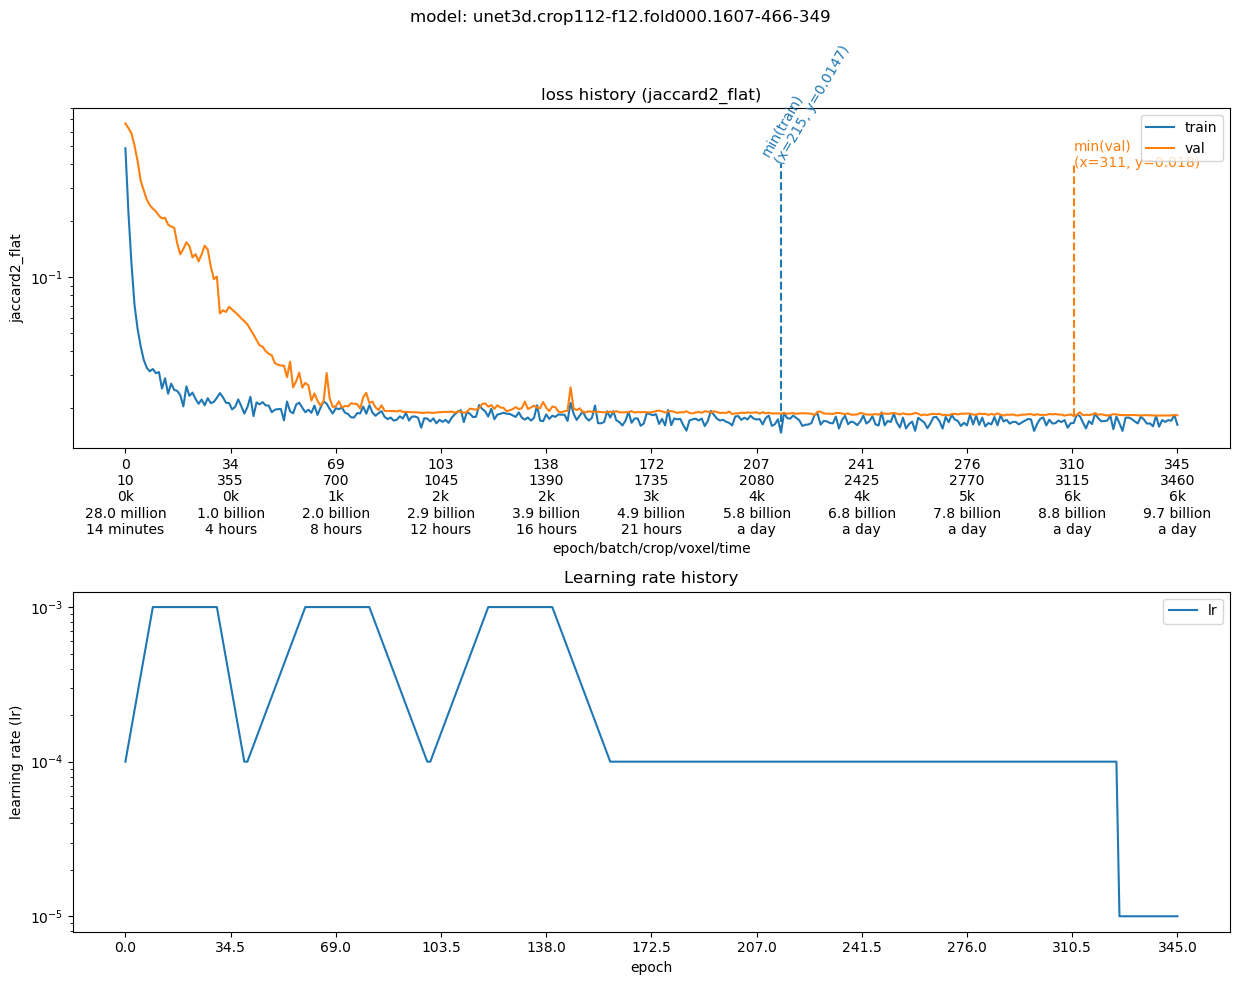

In [53]:
fig, axs = plt.subplots(nrows := 2, ncols := 1, figsize=(2.5 * (sz := 5), nrows * sz), dpi=100)
fig.set_tight_layout(True)

hist_display = viz.TrainingHistoryDisplay(
    history_cb.history, 
    model_name=tomo2seg_model.name,
    loss_name=model.loss.__name__,
    x_axis_mode=(
        "epoch", "batch", "crop", "voxel", "time",
    ),
).plot(
    axs, 
    with_lr=True,
    metrics=(
        "loss", 
    ),
)

axs[0].set_yscale("log")
axs[-1].set_yscale("log")

viz.mark_min_values(hist_display.axs_metrics_[0], hist_display.plots_["loss"][0])
viz.mark_min_values(hist_display.axs_metrics_[0], hist_display.plots_["val_loss"][0], txt_kwargs=dict(rotation=0))

hist_display.fig_.savefig(
    tomo2seg_model.model_path / (hist_display.title + ".png"),
    format='png',
)
# plt.close()

In [54]:
history_cb.dataframe.to_csv(history_cb.csv_path, index=True)

In [55]:
model.save(tomo2seg_model.model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/users/jcasagrande/projects/tomo2seg/data/models/unet3d/unet3d.crop112-f12.fold000.1607-466-349/assets


In [58]:
this_nb_name = "train-04-tomo88.ipynb"
import os
this_dir = os.getcwd()
logger.warning(f"{this_nb_name=} {this_dir=}")

os.system(f"jupyter nbconvert {this_dir}/{this_nb_name} --output-dir {str(tomo2seg_model.model_path)} --to html")

this_nb_name='train-04-tomo88.ipynb' this_dir='/home/users/jcasagrande/projects/tomo2seg/nbs'



0